<a href="https://colab.research.google.com/github/abhranil-datascience/DeepLearning/blob/ImageAnalytics/Day10_MobileNetFromKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################################ Mount Drive and make necessary imports ######################################################
from google.colab import drive
drive.mount('/content/gdrive')

############################## Change Directory ###################################
import os
os.chdir('/content/gdrive/My Drive/ImageAnalytics/Day1-CNN/Dataset')

########## Suppress Warnings ############
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#################### Define Constant Folder Names and Get File Paths ###########################
Dataset='/content/gdrive/My Drive/ImageAnalytics/Day1-CNN/Dataset'
TrainingSet='/training_set'
TestSet='/test_set'
TrainingSetPath=Dataset+TrainingSet
TestSetPath=Dataset+TestSet
cat_folder='/cats'
dog_folder='/dogs'
TrainingSetCat=TrainingSetPath+cat_folder
TrainingSetDog=TrainingSetPath+dog_folder
TestSetCat=TestSetPath+cat_folder
TestSetDog=TestSetPath+dog_folder
TrainingSetCatImages=[TrainingSetCat+"/"+path for path in os.listdir(TrainingSetCat) if '.jpg' in path]
TrainingSetDogImages=[TrainingSetDog+"/"+path for path in os.listdir(TrainingSetDog) if '.jpg' in path]
print("Number of Cats in Training Set: "+str(len(TrainingSetCatImages))+" || Number of Dogs in Training Set: "+str(len(TrainingSetDogImages)))
import random
random.shuffle(TrainingSetCatImages)
random.shuffle(TrainingSetDogImages)

Number of Cats in Training Set: 3928 || Number of Dogs in Training Set: 4000


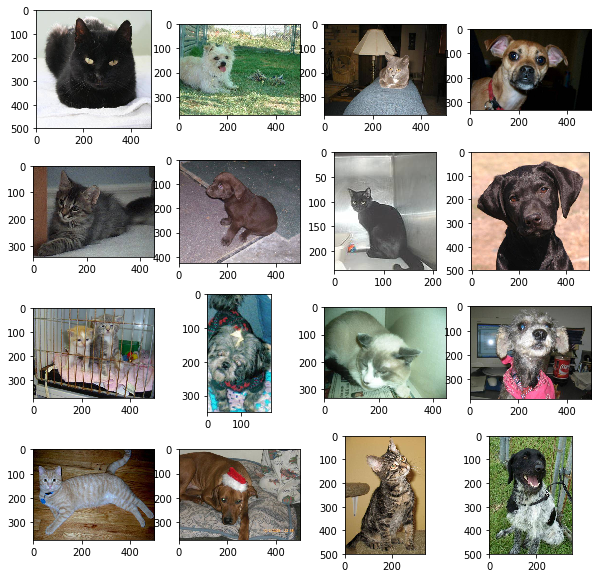

In [3]:
##################################### View Some Cat and Dog Images #####################################
TrainingSetImages=[]
for count in range(0,8):
  TrainingSetImages.append(TrainingSetCatImages[count])
  TrainingSetImages.append(TrainingSetDogImages[count])
import matplotlib.pyplot as plt
import matplotlib.image as mimg
fig=plt.figure(figsize=(10,10))
columns=4
rows=4
for count in range(0,len(TrainingSetImages)):
  curr_img=mimg.imread(TrainingSetImages[count])
  fig.add_subplot(rows,columns,count+1)
  imgplot=plt.imshow(curr_img)
plt.show()

In [4]:
######################################################## Create Image Generator and Preprocess #####################################################################
from keras.preprocessing.image import ImageDataGenerator
TrainImageGenerator=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,vertical_flip=True)
TestImageGenerator=ImageDataGenerator(rescale=1./255)
TrainDataset=TrainImageGenerator.flow_from_directory(directory=TrainingSetPath,target_size=(224,224),batch_size=90,classes=['cats','dogs'],
                                                     class_mode='categorical',shuffle=True)
TestDataset=TestImageGenerator.flow_from_directory(directory=TestSetPath,target_size=(224,224),batch_size=90,classes=['cats','dogs'],
                                                     class_mode='categorical',shuffle=True)
#TrainDataset.class_indices ==> {'cats': 0, 'dogs': 1}
#TestDataset.class_indices ==> {'cats': 0, 'dogs': 1}

Using TensorFlow backend.


Found 7928 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
from keras.applications import mobilenet_v2
mnet=mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
mnet.summary()







Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_________________________________________________________________________

In [6]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
base_model_output=mnet.output
x=GlobalAveragePooling2D()(base_model_output)
x=Dense(units=1024,activation='relu')(x)
x=Dense(units=1024,activation='relu')(x)
x=Dense(units=512,activation='relu')(x)
pred=Dense(units=2,activation='softmax')(x)
mnet_model=Model(mnet.input,pred)
mnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
############################################################ Freeze Initial Layers ################################################################
for layer in mnet.layers:
  layer.trainable=False


In [8]:
########################################### Fit Model and apply callbacks ###################################################################
from keras.callbacks import ModelCheckpoint,EarlyStopping
BestModelName='MobileNetV2_BestModel.hdf5'
BestModelDirectoryPath="/content/gdrive/My Drive/ImageAnalytics/Day10-MobileNetV2FromKeras/BestModel/"
BestModelPath=BestModelDirectoryPath+BestModelName
mnet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
save_best_model=ModelCheckpoint(filepath=BestModelPath,monitor='val_acc',save_best_only=True,mode='max',verbose=2)
early_stop=EarlyStopping(monitor='val_acc',min_delta=0.005,mode='max',restore_best_weights=True,patience=12,verbose=2)
mnet_model.fit_generator(generator=TrainDataset,steps_per_epoch=7928/90,epochs=50,validation_data=TestDataset,validation_steps=2000/90,callbacks=[save_best_model,early_stop],shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
89/88 [==============================] - 139s 2s/step - loss: 0.3112 - acc: 0.8766 - val_loss: 0.0606 - val_acc: 0.9770

Epoch 00001: val_acc improved from -inf to 0.97700, saving model to /content/gdrive/My Drive/ImageAnalytics/Day10-MobileNetV2FromKeras/BestModel/MobileNetV2_BestModel.hdf5
Epoch 2/50
89/88 [==============================] - 121s 1s/step - loss: 0.2010 - acc: 0.9151 - val_loss: 0.1786 - val_acc: 0.9240

Epoch 00002: val_acc did not improve from 0.97700
Epoch 3/50
89/88 [==============================] - 131s 1s/step - loss: 0.1647 - acc: 0.9329 - val_loss: 0.1968 - val_acc: 0.9205

Epoch 00003: val_acc did not improve from 0.97700
Epoch 4/50
89/88 [==============================] - 132s 1s/step - loss: 0.1508 - acc: 0.9389 - val_loss: 0.2458 - val_acc: 0.9040

Epoch 00004: val_acc did not improve from 0.97700
Epoch 5/50
89/88 [==============================] - 132